# Test and Benchmark

In [1]:
using Revise
using VCFTools
using LinearAlgebra
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLD2, FileIO, JLSO
using BenchmarkTools
using GroupSlices

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1273


## Haplotyping timing varying number of haplotypes

In [15]:
Random.seed!(123)
ns = [100, 1000, 10000] # number of individuals
ps = [100, 1000, 10000]    # number of typed SNPs
ds = [100, 1000, 10000]  # number of reference haplotypes
for n in ns, p in ps, d in ds
    H = convert(Matrix{Float32}, rand(0:1, p, d))
    X = convert(Matrix{Float32}, rand(0:2, p, n))
    M = Transpose(H) * H
    for j in 1:d, i in 1:(j - 1) # off-diagonal
        M[i, j] = 2M[i, j] + M[i, i] + M[j, j]
    end
    for j in 1:d # diagonal
        M[j, j] *= 4
    end
    N = Transpose(X) * H
    for I in eachindex(N)
        N[I] *= 2
    end
    happair  = zeros(Int, n), zeros(Int, n)
    hapscore = zeros(eltype(N), n)
    t = @elapsed haplopair!(happair, hapscore, M, N)
    println("n = $n, p = $p, d = $d time = $t")
end

n = 100, p = 100, d = 100 time = 0.000456208
n = 100, p = 100, d = 1000 time = 0.038313572
n = 100, p = 100, d = 10000 time = 3.35376975
n = 100, p = 1000, d = 100 time = 0.0003795
n = 100, p = 1000, d = 1000 time = 0.038590982
n = 100, p = 1000, d = 10000 time = 3.374475433
n = 100, p = 10000, d = 100 time = 0.000484978
n = 100, p = 10000, d = 1000 time = 0.03808498
n = 100, p = 10000, d = 10000 time = 3.397484089
n = 1000, p = 100, d = 100 time = 0.004034878
n = 1000, p = 100, d = 1000 time = 0.3387065
n = 1000, p = 100, d = 10000 time = 34.682602842
n = 1000, p = 1000, d = 100 time = 0.004231036
n = 1000, p = 1000, d = 1000 time = 0.375277053
n = 1000, p = 1000, d = 10000 time = 36.049891365
n = 1000, p = 10000, d = 100 time = 0.003922379
n = 1000, p = 10000, d = 1000 time = 0.403318508
n = 1000, p = 10000, d = 10000 time = 35.155680319
n = 10000, p = 100, d = 100 time = 0.040836424
n = 10000, p = 100, d = 1000 time = 3.727595042
n = 10000, p = 100, d = 10000 time = 355.668273795
n 

# Try using Distance package

In [2]:
Random.seed!(123)

n = 1000
p = 100
d = 1000

H = bitrand(p, d)
X = Matrix{Union{UInt8, Missing}}(rand(UInt8, p, n));

In [4]:
@time happairs, hapscore = haplopair(X, H)

  0.459777 seconds (19 allocations: 8.412 MiB)


(([340, 340, 340, 133, 340, 340, 340, 340, 133, 143  …  765, 860, 340, 340, 340, 340, 229, 340, 197, 340], [340, 340, 340, 133, 340, 340, 340, 340, 133, 765  …  765, 860, 340, 340, 340, 340, 229, 340, 197, 340]), Float32[1.913391e6, 2.013669e6, 1.960055e6, 2.147745e6, 2.296302e6, 2.009172e6, 2.002896e6, 2.381612e6, 2.179918e6, 1.994983e6  …  1.829199e6, 1.990567e6, 2.154802e6, 2.52563e6, 2.222577e6, 2.076442e6, 2.185664e6, 2.285618e6, 2.00884e6, 2.227455e6], 0, 0.003642989, 0.453925324, 0)

In [7]:
@time happairs, hapscore = haplopair_thin(X, H, keep = 1000)

  3.696501 seconds (6.73 k allocations: 12.437 MiB)


(([340, 340, 340, 133, 340, 340, 340, 340, 133, 143  …  765, 860, 340, 340, 340, 340, 229, 340, 197, 340], [340, 340, 340, 133, 340, 340, 340, 340, 133, 765  …  765, 860, 340, 340, 340, 340, 229, 340, 197, 340]), Float32[1.913391e6, 2.013669e6, 1.960055e6, 2.147745e6, 2.296302e6, 2.009172e6, 2.002896e6, 2.381612e6, 2.179918e6, 1.994983e6  …  1.829199e6, 1.990567e6, 2.154802e6, 2.52563e6, 2.222577e6, 2.076442e6, 2.185664e6, 2.285618e6, 2.00884e6, 2.227455e6], 0.00428477, 0.003716978, 3.6868725430000002, 0)

In [ ]:
linsp = 100:1000:11000
t1 = zeros(length(linsp))
t2 = zeros(length(linsp))
n = 100
p = 100

Random.seed!(2020)
for (i, d) in enumerate(linsp)
    H = bitrand(p, d)
    X = Matrix{Union{UInt8, Missing}}(rand(UInt8, p, n));
    t1[i] = @elapsed haplopair(X, H)
    t2[i] = @elapsed haplopair_thin(X, H, keep = 100)
end

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


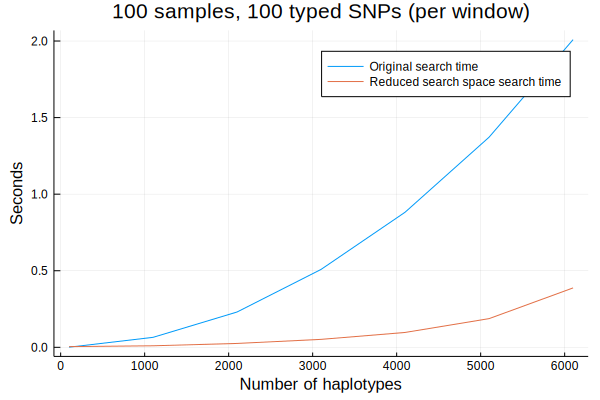

In [10]:
using Plots
x = plot(linsp, t1, title="100 samples, 100 typed SNPs (per window)",
    label="Original search time", ylabel="Seconds", xlabel="Number of haplotypes")
plot!(x, linsp, t2, label="Reduced search space search time")

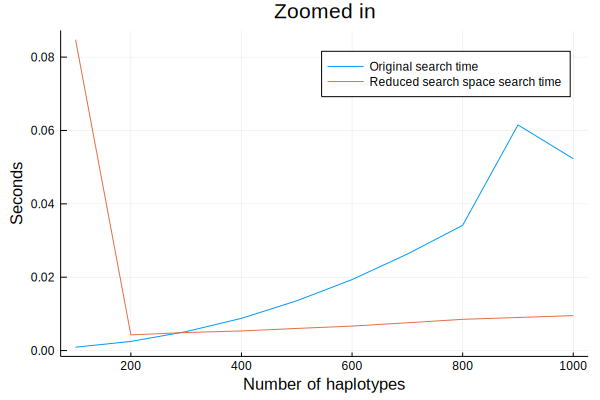

In [11]:
# ZOOM in

linsp = 100:100:1000
t1 = zeros(length(linsp))
t2 = zeros(length(linsp))
n = 100
p = 100

Random.seed!(2020)
for (i, d) in enumerate(linsp)
    H = bitrand(p, d)
    X = Matrix{Union{UInt8, Missing}}(rand(UInt8, p, n));
    t1[i] = @elapsed haplopair(X, H)
    t2[i] = @elapsed haplopair_thin(X, H, keep = 100)
end
y = plot(linsp, t1, title = "Zoomed in", label="Original search time", 
    ylabel="Seconds", xlabel="Number of haplotypes")
plot!(y, linsp, t2, label="Reduced search space search time")

In [31]:
savefig(y, "zoom_in.png")
savefig(x, "zoom_out.png")

# Benchmark original code

In [14]:
Random.seed!(123)

n = 100
p = 100
d = 1000

M = rand(Float32, d, d)
N = rand(Float32, n, d)
H = convert(Matrix{Float32}, rand(0:1, p, d))
X = convert(Matrix{Float32}, rand(0:2, p, n))
happair1 = zeros(Int, n)
happair2 = zeros(Int, n)
hapscore = zeros(Float32, n)

@btime haplopair!(happair1, happair2, hapscore, M, N) setup=(M=rand(Float32, d, d), N=rand(Float32, n, d))

  29.677 ms (0 allocations: 0 bytes)


In [12]:
Random.seed!(123)

n = 100
p = 100
d = 1000

M = rand(Float32, d, d)
N = rand(Float32, n, d)
H = convert(Matrix{Float32}, rand(0:1, p, d))
X = convert(Matrix{Float32}, rand(0:2, p, n))
happairs = zeros(Int, n), zeros(Int, n)
hapscore = zeros(Float32, n)

@btime haplopair!(happairs, hapscore, M, N) setup=(M=rand(Float32, d, d), N=rand(Float32, n, d))

  35.057 ms (0 allocations: 0 bytes)
